In [1]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from mat_utils import *
from block_matrix import *
from experiments.thermal.thm_models import make_model
import porepy as pp


model = make_model(
    {
        'physics': 1,
        "geometry": 0,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 3,
        "solver": 2,
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore




Sim time: 0.0, Dt: 100000.0
sticking: 0, sliding: 0, open: 0


/home/porepy/.local/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/porepy/.local/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


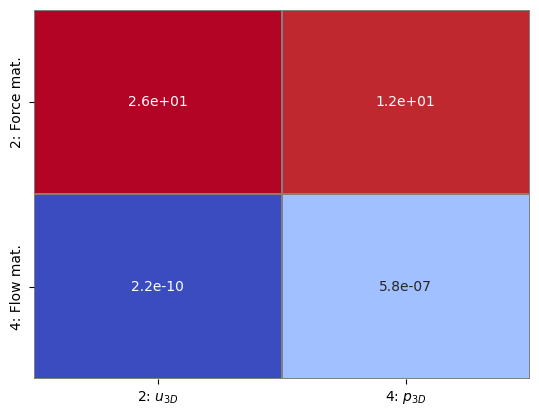

In [2]:
data = load_data(f"../../stats/{model.simulation_name()}.json")
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    data, 2, "../../matrices"
)
model.linear_system = mat, rhs
model.bmat.mat = mat
J = model.bmat[:]
J.plot_max()

Solve  took: 0.04
True residual: 2.0229666668066388e-11
PETSc Converged Reason: 2


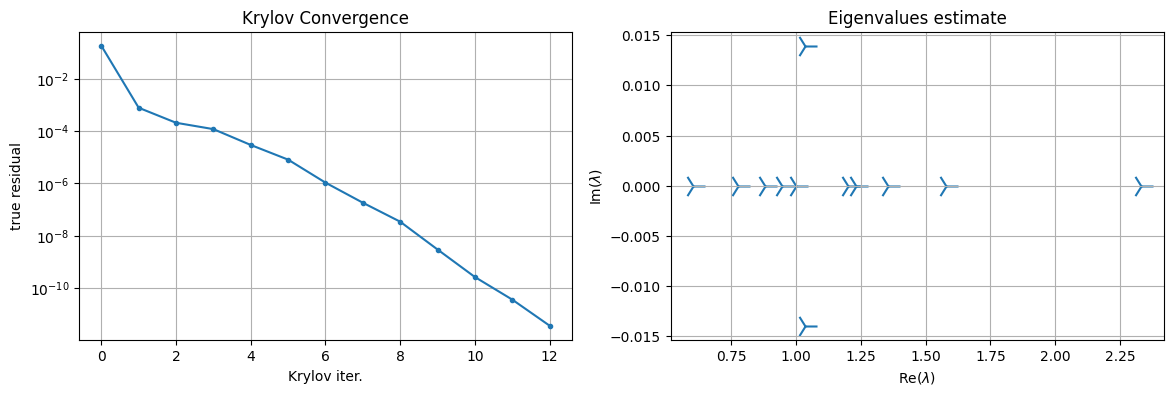

In [23]:
from fixed_stress import (
    make_fs_analytical,
    make_fs_thermal,
    block_matrix,
    get_fixed_stress_stabilization_energy,
    get_fs_fractures_analytical,
    get_fixed_stress_stabilization,
)
from hm_solver import build_mechanics_near_null_space

solve_petsc_3(
    bmat=J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp='richardson',
        preconditioner=FieldSplitScheme(
            groups=[2],
            solve=lambda bmat: PetscAMGMechanics(
                mat=bmat[[2]].mat,
                dim=model.nd,
                null_space=build_mechanics_near_null_space(model, include_intf=True),
            ),
            invertor_type="physical",
            invertor=lambda bmat: block_matrix(
                bmat[[4]],
                {
                    (4, 4): get_fixed_stress_stabilization(model, l_factor=0.6),
                },
            ).mat * 0,
            complement=FieldSplitScheme(
                groups=[4],
                solve=lambda bmat: PetscAMGFlow(bmat.mat),
            ),
        ),
    ),
)

Solve  took: 0.22
True residual: 15537379.76243407
PETSc Converged Reason: -4


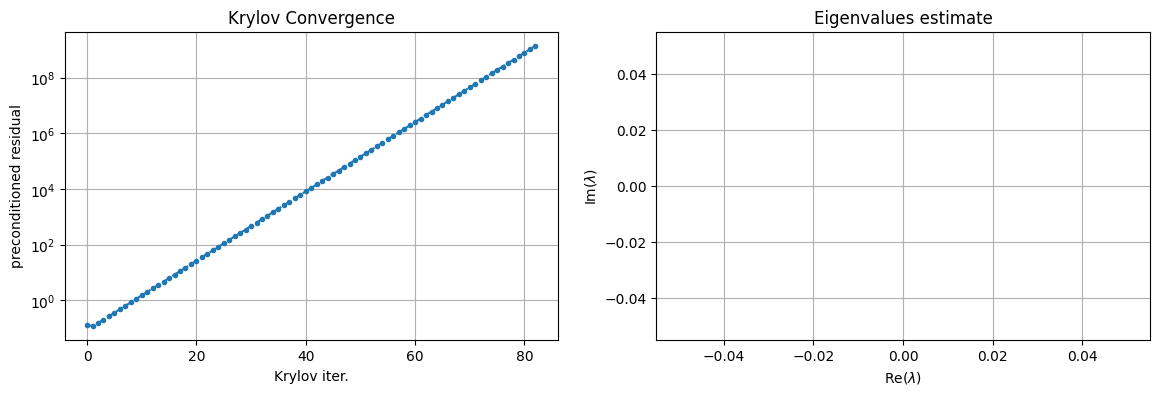

In [18]:
solve_petsc_3(
    bmat=J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp='richardson',
        preconditioner=FieldSplitScheme(
            groups=[0],
            solve=lambda bmat: inv_block_diag(mat=bmat[[0]].mat, nd=model.nd),
            complement=FieldSplitScheme(
                groups=[1],
                solve=lambda bmat: PetscILU(bmat[[1]].mat),
                invertor=lambda bmat: extract_diag_inv(bmat[[1]].mat),
                complement=FieldSplitScheme(
                    groups=[2, 3],
                    solve=lambda bmat: PetscAMGMechanics(
                        mat=bmat[[2, 3]].mat,
                        dim=model.nd,
                        null_space=build_mechanics_near_null_space(model),
                    ),
                    invertor_type="physical",
                    invertor=lambda bmat: make_fs_analytical(
                        model, bmat, p_mat_group=4, p_frac_group=5
                    ).mat * 0,
                    complement=FieldSplitScheme(
                        groups=[4, 5],
                        solve=lambda bmat: PetscAMGFlow(mat=bmat[[4, 5]].mat),
                    ),
                ),
            ),
        ),
    ),
)